In [13]:
!pip install prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [14]:
df = pd.read_csv("Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv")
df.head()


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,30/08/2024,16436,10705,225,19026,3925,59.0
1,15/09/2023,15499,10671,267,18421,4519,61.0
2,28/12/2021,1756,2352,0,3775,0,13.0
3,11/01/2023,10536,8347,223,14072,0,48.0
4,11/09/2021,820,612,0,1283,0,11.0


In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

service_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']
df.set_index('Date', inplace=True)

df[service_cols].describe()

,Local Route,Light Rail,Peak Service,Rapid Route,School
count,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000
mean,9891.395203,7195.446298,179.581335,12597.213243,2352.694995
std,6120.715714,3345.616428,156.532738,6720.494557,2494.766306
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3044.500000,4463.500000,0.000000,6383.000000,0.000000
50%,11417.000000,7507.000000,193.000000,13106.500000,567.500000
75%,15517.500000,10008.250000,313.750000,17924.750000,4914.000000
max,21070.000000,15154.000000,1029.000000,28678.000000,7255.000000


In [16]:
df['Day'] = df.index.day_name()
weekday_avg = df[df['Day'].isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])][service_cols].mean()
weekend_avg = df[df['Day'].isin(['Saturday','Sunday'])][service_cols].mean()

(weekday_avg - weekend_avg).sort_values()

,0
Peak Service,251.413869
School,3293.619708
Light Rail,4061.291606
Rapid Route,9450.227007
Local Route,10023.835401


In [17]:
breaks = {}
for c in service_cols:
    df['roll_mean'] = df[c].rolling(window=7).mean()
    diff = df['roll_mean'].diff().abs()
    breaks[c] = diff.nlargest(3).index.strftime("%Y-%m-%d").tolist()
breaks

{'Local Route': ['2024-09-24', '2020-03-09', '2024-09-25'],
 'Light Rail': ['2024-09-25', '2024-09-24', '2019-12-25'],
 'Peak Service': ['2023-11-17', '2023-11-10', '2020-03-09'],
 'Rapid Route': ['2019-12-25', '2024-09-24', '2024-09-25'],
 'School': ['2020-02-06', '2020-02-05', '2021-02-04']}

In [18]:
lead_lag = {}
for a in service_cols:
    for b in service_cols:
        if a != b:
            corr = df[a].shift(2).corr(df[b])  # check 2-day lead
            if corr > 0.5:
                lead_lag[f"{a} leads {b}"] = round(corr,3)
lead_lag

{}

In [19]:
vol = df[service_cols].rolling(window=7).std().mean().sort_values(ascending=False)
vol

,0
Local Route,5258.086918
Rapid Route,5022.710006
Light Rail,2256.838334
School,1779.231729
Peak Service,133.470361


In [20]:
share = df[service_cols].div(df[service_cols].sum(axis=1), axis=0)
share.tail()


,Local Route,Light Rail,Peak Service,Rapid Route,School
Date,,,,,
2024-09-25,0.525000,0.0,0.025,0.250000,0.200000
2024-09-26,0.818182,0.0,0.000,0.000000,0.181818
2024-09-27,0.315789,0.0,0.000,0.684211,0.000000
2024-09-28,0.200000,0.0,0.000,0.800000,0.000000
2024-09-29,0.250000,0.0,0.000,0.750000,0.000000


In [22]:
from prophet import Prophet
def forecast_series(df, col):
    temp = df[[col]].reset_index()
    temp.columns = ['ds', 'y']

    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(temp)

    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    return forecast[['ds','yhat','yhat_lower','yhat_upper']]


In [23]:
forecasts = {}
for col in service_cols:
    forecasts[col] = forecast_series(df, col)

forecasts['Local Route'].tail(10)


,ds,yhat,yhat_lower,yhat_upper
1915,2024-09-27,11910.691541,7926.462226,15903.088475
1916,2024-09-28,2546.005279,-1526.668334,6520.187011
1917,2024-09-29,1402.589949,-2668.834812,5618.648501
1918,2024-09-30,10605.076826,6412.739414,14638.233059
1919,2024-10-01,12400.978695,8328.521480,16168.072401
1920,2024-10-02,12566.123700,8625.625860,16668.087286
1921,2024-10-03,12416.430193,8454.918244,16473.092486
1922,2024-10-04,11887.680495,7984.082310,15929.326623
1923,2024-10-05,2740.383506,-1258.715769,6920.585420
1924,2024-10-06,1816.001232,-2612.420015,5692.712697


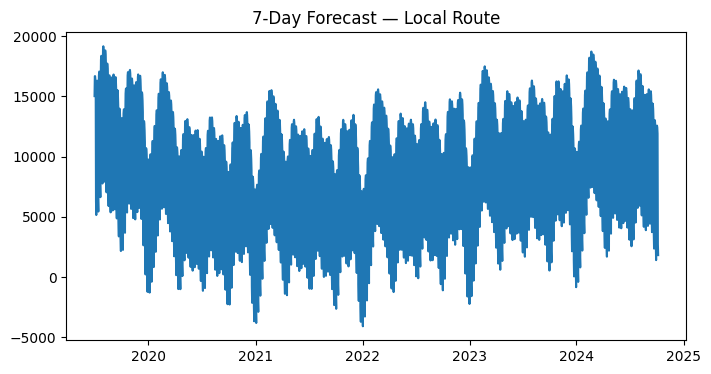

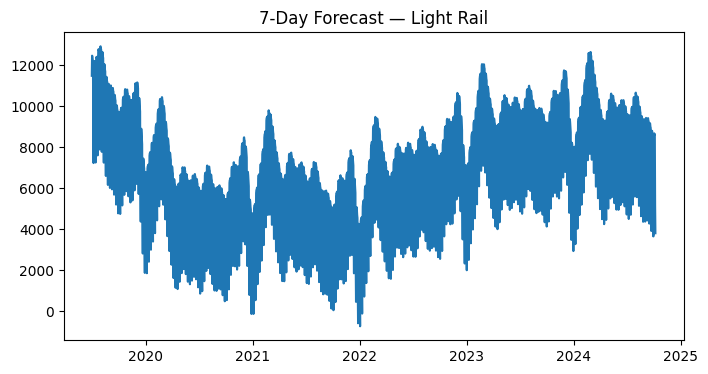

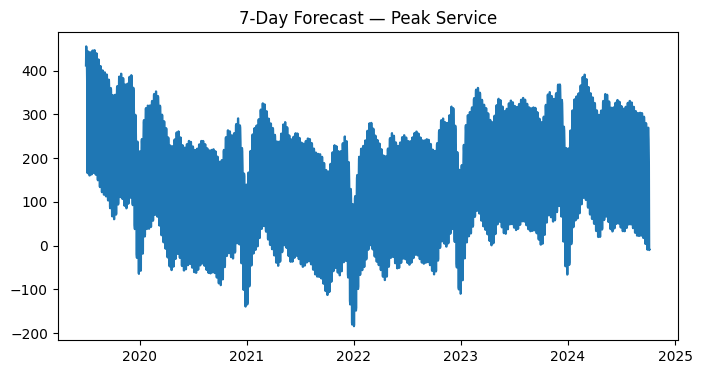

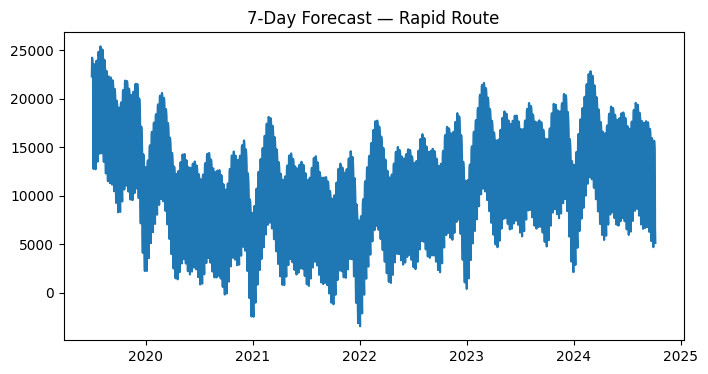

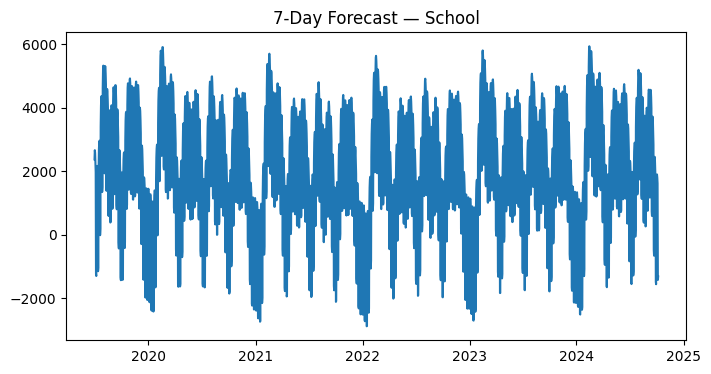

In [24]:
for col in service_cols:
    f = forecasts[col]
    plt.figure(figsize=(8,4))
    plt.plot(f['ds'], f['yhat'])
    plt.title(f"7-Day Forecast — {col}")
    plt.show()


In [26]:
for col in service_cols:
    forecasts[col].to_csv(f"{col}_7day_forecast.csv", index=False)
